# Deep Convolutional Generative Adversarial Network - Anime Faces

### Setup

In [1]:
# To generate GIFs
%pip install -q imageio pydot tensorflow keras matplotlib graphviz moviepy


Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython import display
import time
from IPython.display import Image
import os
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio
import math
import glob
import PIL
import PIL.Image

import tensorflow as tf


2022-05-07 18:23:29.650876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 18:23:29.650896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from keras import layers, backend
import keras


In [4]:
tf.__version__


'2.8.0'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [5]:
def load_from_directory(data_dir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    # Search and find number of elements within directory, recursively.
    image_count = len(list(data_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_dir, image_count))

    #
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1. / 255.0)

    # Translate [0,255] -> [-1, 1]
    normalized_ds = configure_for_performance(train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0),
                                              AUTOTUNE)

    return normalized_ds


In [6]:

latent_space_size = 128
BATCH_SIZE = 128
IMAGE_SIZE = (128, 128)
EPOCHS = 64

data_directory_path = "data/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data: Found 26374 files
Found 26374 files belonging to 1 classes.
Number of batches 207 of 128 elements


2022-05-07 18:23:34.243585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 18:23:34.243608: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 18:23:34.243622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (enomoto): /proc/driver/nvidia/version does not exist
2022-05-07 18:23:34.243976: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size.

In [7]:
def make_generator_model(input_shape):
    model = tf.keras.Sequential()

    init = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - 4, 0)

    # foundation for 4x4 image
    n_nodes = 1024 * 4 * 4
    model.add(layers.Dense(
        n_nodes, kernel_initializer=init, input_dim=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    # Note: None is the batch size
    assert model.output_shape == (None, 4, 4, 1024)

    # upsample to 8x8
    model.add(layers.Conv2DTranspose(filters=1024, kernel_size=(4, 4), strides=(2, 2),
                                     use_bias=False, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    for i in range(0, num_layers + 1):
        filter_size = int(512 / (2 ** i))
        image_size = (16 * (2 ** i), 16 * (2 ** i))

        model.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same',
                                         kernel_initializer=init))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        assert model.output_shape == (
            None, image_size[0], image_size[1], filter_size)

    # output layer
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(
        1, 1), padding='same', kernel_initializer=init))
    model.add(layers.Activation('tanh'))
    # TODO add color channel
    assert model.output_shape == (None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    return model

Use the (as yet untrained) generator to create an image.

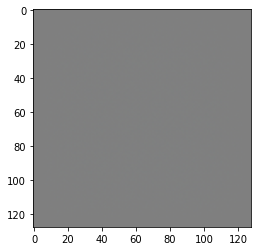

In [8]:

latent_space_c = (latent_space_size)
generator = make_generator_model(latent_space_c)

noise = tf.random.normal([1, latent_space_size])

generated_image = generator(noise, training=False)

# Convert image from [-1,1] to [0,1]
rgb = (generated_image[0, :, :, 0:3] + 1.0) / 2.0

plt.imshow(asarray(rgb))


### The Discriminator

The discriminator is a CNN-based image classifier.

In [9]:
""" def make_discriminator_model(input_shape):
        model = Sequential()
        #model.add(layers.Rescaling(1. / 255, input_shape=input_shape))
        # normal
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # downsample
        model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # classifier
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        # compile model
        #opt = Adam(lr=0.0002, beta_1=0.5)
        #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model """


def make_discriminator_model():
    model = tf.keras.Sequential()

    n_layers = max(int(math.log2(IMAGE_SIZE[1])) - 3, 0)

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), use_bias=False, padding='same',
                            input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    for i in range(0, n_layers):
        filter_size = 128 * (2 ** i)
        kernel_size = (5, 5)
        model.add(layers.Conv2D(filter_size, kernel_size=kernel_size,
                                strides=(2, 2), use_bias=False, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1, kernel_size=4, strides=(
        2, 2), padding='valid', use_bias=False))
    model.add(layers.Flatten())
    #model.add(layers.Dropout(0.3))
    model.add(layers.Activation('sigmoid'))

    return model


Example of using the discriminator for determine if a image is real. However, since either model are trained, the result will not be useful.

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.50004566]], shape=(1, 1), dtype=float32)


## Generator Model

In [11]:
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 1024)       16777216  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 1024)       4

## Discriminator Model

In [12]:
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1728      
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)      

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [13]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)


In [14]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


def generate_and_save_images(model, epoch, latent_space):
    fig = generate_grid_image(model=model, latent_space=latent_space)
    fig.savefig('image_at_epoch_{:04d}.png'.format(epoch), transparent=False)
    plt.show()


In [15]:
# Generate a big image.
def generateBigBridImage(model, grid_size, latent_space=None):
    width, height = grid_size

    if latent_space == None:
        latent_space = tf.random.normal([width * height, latent_space_size])

    generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(width * 2, height * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(height, width, i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()
    return fig


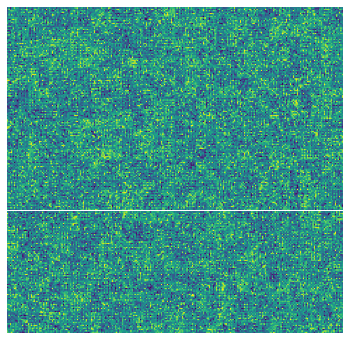

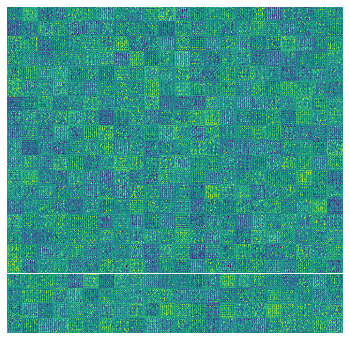

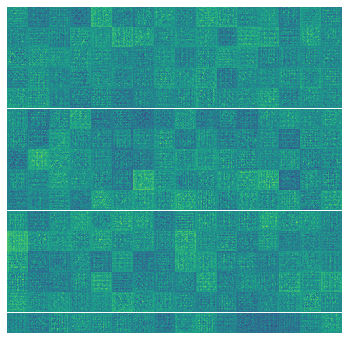

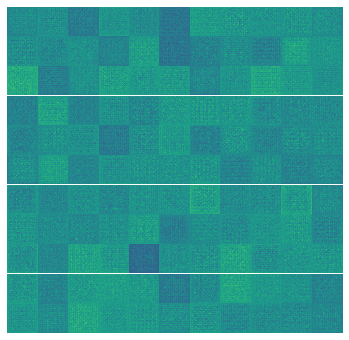

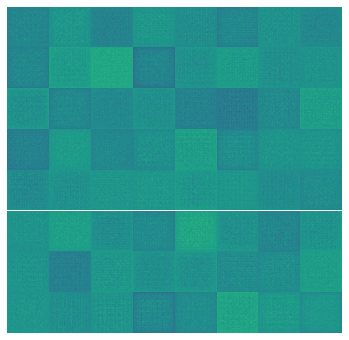

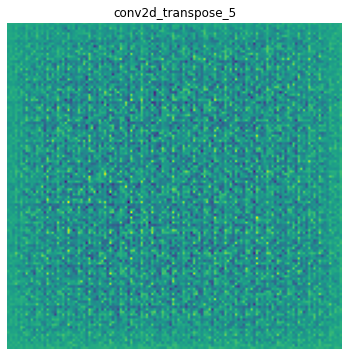

In [16]:
def get_layer_outputs(model, layer_name, input_data):
    layer_output=model.get_layer(layer_name).output

    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

    intermediate_prediction=intermediate_model(input_data, training=False)
    return intermediate_prediction

def generate_each_layer(model, latent_space, grid_size):
    inp = model.input                                           # input placeholder
    
    # Testing
    test = np.random.random(latent_space.shape)[np.newaxis, ...]
    for layer in generator.layers:
        
        if 'conv2d' in layer.name:
            layer_outs = get_layer_outputs(generator, layer.name, latent_space)

            #
            width, height = grid_size
            nr_filters = layer_outs.shape[3]
            nr_images = layer_outs.shape[0]
            square = int(math.sqrt(nr_filters))

            #
            fig = plt.figure(figsize=(width * 2, height * 2))
            plt.title(layer.name)

            for i in range(nr_images):
                for k in range(0, nr_filters):
                    if k < square * square:

                        plt.subplot(square, square, k+1)

                        plt.imshow(((layer_outs[i, :, :, k] + 1.0) / 2.0), aspect='auto')
                        plt.axis("off")
            plt.subplots_adjust(wspace=0.005, hspace=0.005)
            plt.show()

grid_size = (3, 3)
noise__ = tf.random.normal([1, latent_space_size])
generate_each_layer(generator, noise__, grid_size)


In [17]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show(block=False)


2022-05-07 18:24:19.265171: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


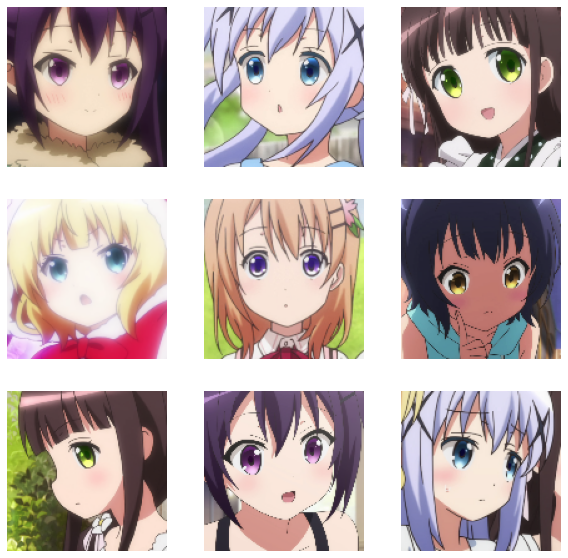

In [18]:
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF.
seed = tf.random.normal([num_examples_to_generate, latent_space_size])

plt.figure(figsize=(10, 10))
for images in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((images[i].numpy() + 1.0) / 2.0)
        plt.axis("off")
plt.show()

#grid_size = (3, 3)
#layer_fig = generate_each_layer(generator, latent_space_c, grid_size)
# layer_fig.show()


In [19]:

class DCGAN(keras.Model):

    def __init__(self, generator_model, discriminator_model, **kwargs):

        super(DCGAN, self).__init__(**kwargs)
        self.generator = generator_model
        self.discriminator = discriminator_model
        self.latent_space_size = generator_model.input_shape

        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(
            from_logits=False)

    def generator_loss(self, fake_output):

        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output, smooth=0.11):

        # label for real image is (1-smooth)
        real_loss = self.cross_entropy(tf.ones_like(
            real_output)*(1-smooth), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        
        return total_loss

    def compile(self, generator_optimizer, discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    @tf.function
    def train_step(self, data):

        batch_size = tf.shape(data)[0]
        # TODO resolve
        batch_size = 128
        self.latent_space_size = 128

        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size, self.latent_space_size))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            # generate image using generator
            generated_image = self.generator(seed, training=True)

            # discriminator's prediction for real image
            real_output = self.discriminator(data, training=True)

            # discriminator's estimate for fake image
            fake_output = self.discriminator(
                generated_image, training=True)

            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(
                gen_loss, self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(
                disc_loss, self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(
                zip(generator_grad, self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(discriminator_grad, self.discriminator.trainable_variables))

        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }


In [20]:
class checkpoint_callback(tf.keras.callbacks.Callback):

    def __init__(self, generator_path, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.generator_path = generator_path

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save_weights("Weights/generator_weights.h5")
        self.model.discriminator.save_weights(
            "Weights/discriminator_weights.h5")
        self.model.generator.save(self.generator_path)


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, noise, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.noise = noise

    def on_epoch_end(self, epoch, logs=None):
        generate_and_save_images(self.model.generator, epoch, self.noise)
        grid_size = (16, 9)
        big_fig = generateBigBridImage(generator, grid_size)
        big_fig.savefig('big_image_at_epoch_{:04d}.png'.format(
            epoch + 1), transparent=None)


Epoch 1/64
207/207 [==============================] - 2793s 13s/step - generator loss: 7.9610 - discriminator_loss: 1.6300
Epoch 2/64
207/207 [==============================] - 2639s 13s/step - generator loss: 2.2166 - discriminator_loss: 1.0631
Epoch 3/64
207/207 [==============================] - 2653s 13s/step - generator loss: 2.4404 - discriminator_loss: 0.9148
Epoch 4/64
207/207 [==============================] - 2648s 13s/step - generator loss: 1.9911 - discriminator_loss: 1.0702
Epoch 5/64
207/207 [==============================] - 2726s 13s/step - generator loss: 2.0779 - discriminator_loss: 1.0076
Epoch 6/64
207/207 [==============================] - 2799s 14s/step - generator loss: 2.1821 - discriminator_loss: 0.9463
Epoch 7/64
207/207 [==============================] - 2797s 14s/step - generator loss: 2.4006 - discriminator_loss: 0.8999
Epoch 8/64
207/207 [==============================] - 2795s 14s/step - generator loss: 2.2861 - discriminator_loss: 0.9210
Epoch 9/64
207/2

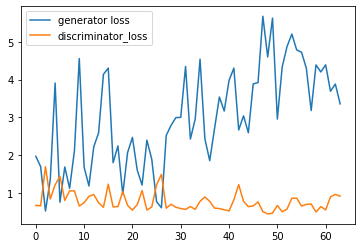

In [21]:
generator_model_filepath = "dcgan-anime-generator.h5"

generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5)


fixed_latent_space_noise = tf.random.normal(
    [num_examples_to_generate, latent_space_size])
dcgan = DCGAN(generator, discriminator)
dcgan.compile(generator_optimizer, discriminator_optimizer)
history = dcgan.fit(train_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[
                        save_images(noise=fixed_latent_space_noise),
                        checkpoint_callback(generator_path=generator_model_filepath)
                    ]
                    )
plotCostHistory(history.history)


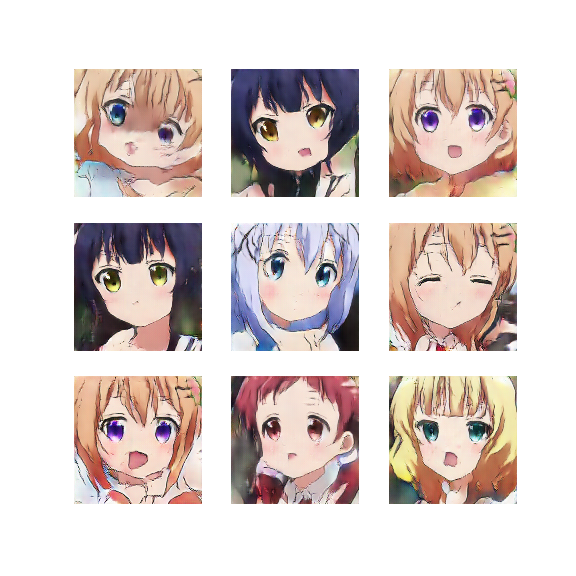

In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


display_image(EPOCHS)


## Save Final Models

In [24]:
generator_model_filepath = "dcgan-anime-generator.h5"
generator.save(generator_model_filepath)
discriminator.save("dcgan-anime-discriminator.h5")


## Load Model and Generator Results

In [25]:
generator_model_filepath = "dcgan-anime-generator.h5"
generator = tf.keras.models.load_model(generator_model_filepath)


In [26]:
grid_size = (14, 6)
generateBigBridImage(generator, grid_size)
plt.show()


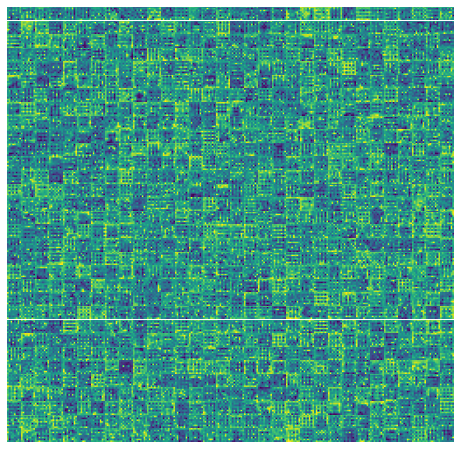

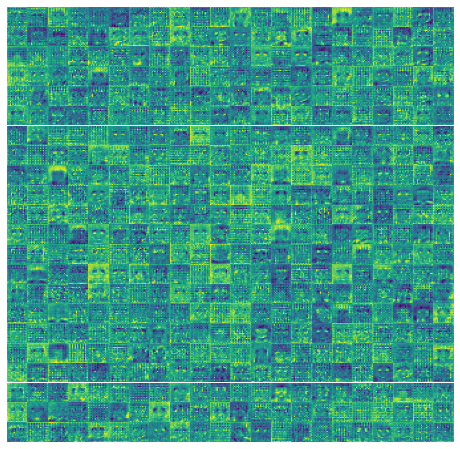

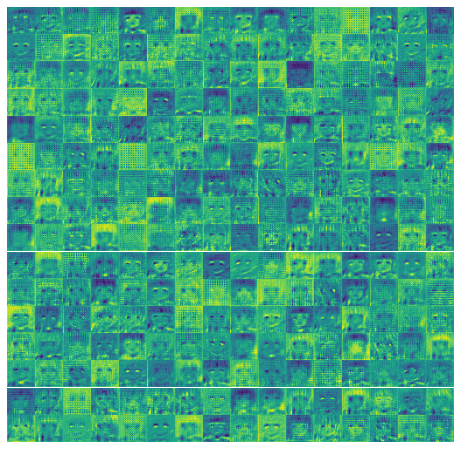

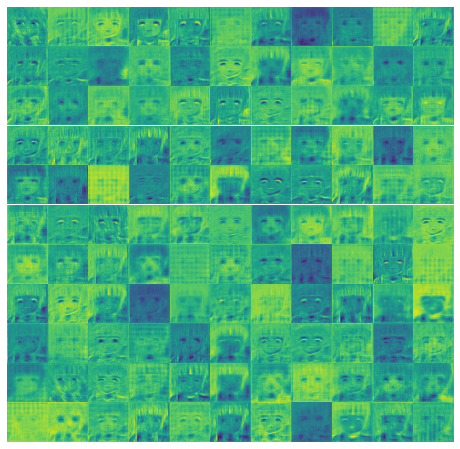

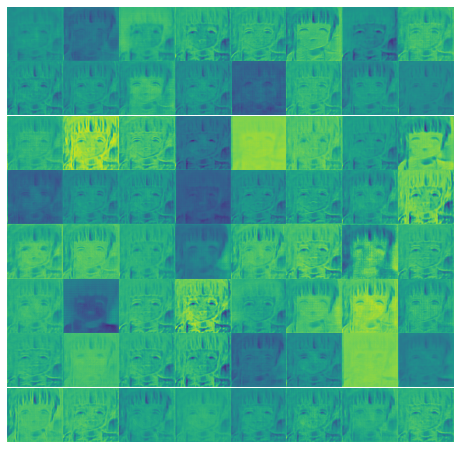

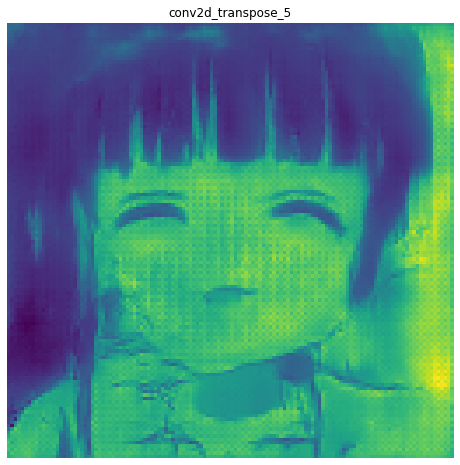

In [27]:
grid_size = (4, 4)
noise__ = tf.random.normal([16, latent_space_size])
generate_each_layer(generator, noise__, grid_size)

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

In [28]:
anim_file = 'anime-dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


Image(url=anim_file)


## Generate Transition Image

By adjusting between two points within the latent space and interpolated.

In [29]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [30]:
def generate_transition(model, gris_size):
      nr_elemenets = 4
      seeds = np.random.randint(10000, size=2)
      zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
            for s in seeds]
      
      all_latents = interpolate(zs, nr_elemenets)

      generated_images = model(latent_space, training=False)

      fig = plt.figure(figsize=(width * 2, height * 2))
      for i in range(generated_images.shape[0]):
            plt.subplot(height, width, i+1,)

            plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
            plt.axis("off")
      plt.subplots_adjust(wspace=0, hspace=0)
      plt.close()



In [31]:
import scipy
import moviepy.editor


In [32]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 9

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    #
    fig = generate_grid_image(generator, latents, (5, 5), (3, 3))

    #
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('transition_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file transition_grid_1406.gif with imageio.


In [33]:
Image(url=gif_filepath)
